# SensRay Ray Tracing & Sensitivity Kernels Demo

This notebook demonstrates:
- Ray tracing with ObsPy/TauP integration
- Computing per-cell ray path lengths
- Calculating sensitivity kernels
- Visualizing rays and kernels in cross-sections

In [1]:
import os
# Top-level INTERACTIVE switch: set to True for interactive Jupyter widgets,
# or False to force static/off-screen rendering and enable screenshot-based outputs.
INTERACTIVE = True

# If not interactive, set PyVista to off-screen mode. If interactive, prefer ipyvtklink/panel.
if not INTERACTIVE:
    os.environ['PYVISTA_OFF_SCREEN'] = 'true'
    os.environ['PYVISTA_USE_IPYVTK'] = 'false'
else:
    os.environ.pop('PYVISTA_OFF_SCREEN', None)
    # Prefer ipyvtklink for Jupyter interactive 3D plots (requires ipyvtklink installed)
    os.environ['PYVISTA_USE_IPYVTK'] = 'true'

import numpy as np
from sensray import PlanetModel, CoordinateConverter

# Configure PyVista backend according to INTERACTIVE flag
try:
    import pyvista as pv
    if INTERACTIVE:
        try:
            pv.set_jupyter_backend('ipyvtklink')
            print("Configured PyVista for interactive plotting using ipyvtklink")
        except Exception:
            try:
                pv.set_jupyter_backend('panel')
                print("Configured PyVista for interactive plotting using panel")
            except Exception as e:
                print(f"Warning: Could not set interactive PyVista backend: {e}")
    else:
        pv.set_jupyter_backend('static')
        print("Configured PyVista for static/off-screen plotting")
except Exception as e:
    print(f"Warning: Could not import/configure pyvista: {e}")

Use one of the following:
"static", "client", "server", "trame", "html", "none"


## 1. Setup Model and Mesh

Create a model and mesh for ray tracing experiments.

### Creating a layered tetrahedral mesh (discontinuities)

This demo uses a layered, concentric-sphere tetrahedral mesh so you can control resolution across major internal interfaces (discontinuities). The mesher accepts these main controls:

- `radii` (list of floats, ascending): interface radii in km (last entry must be the outer radius).
- `H_layers` (list of floats): target element size per layer (km). If `None`, `mesh_size_km` is used for all layers.
- `W_trans` (list of floats): half-widths for smooth size transitions at interfaces (km). If omitted, a default ~0.2*layer_thickness is used.

Notes:
- Units are kilometres throughout the API.
- For a uniform sphere just omit `radii` and set `mesh_size_km`.

Example (run this when creating a new mesh):
```python
radii = [1221.5, 3480.0, 6371.0]
H_layers = [500.0, 500.0, 300.0]
W_trans = [50.0, 100.0]  # optional
# Create mesh (use do_optimize=False for faster development)
model.create_mesh(mesh_size_km=1000.0, radii=radii, H_layers=H_layers, W_trans=W_trans, do_optimize=False)
model.mesh.populate_properties(['vp', 'vs', 'rho'])
model.mesh.save('prem_mesh.vtu')  # file extension recommended
```

In [2]:
# Load model and create mesh
model = PlanetModel.from_standard_model('prem')
# Create mesh and save if not exist, otherwise load existing
mesh_path = "prem_mesh"
try:
    model.create_mesh(from_file=mesh_path)
    print(f"Loaded existing mesh from {mesh_path}")
except FileNotFoundError:
    print("Creating new mesh...")
    radii = [1221.5, 3480.0, 6371]
    H_layers = [1000, 1000, 600]
    model.create_mesh(mesh_size_km=1000, radii=radii, H_layers=H_layers)
    model.mesh.populate_properties(['vp', 'vs', 'rho'])
    model.mesh.save("prem_mesh")  # Save mesh to VT
print(f"Created mesh: {model.mesh.mesh.n_cells} cells")

Loaded mesh from prem_mesh.vtu
Loaded metadata: 18337 cells, 3988 points
Loaded existing mesh from prem_mesh
Created mesh: 18337 cells


## 2. Define Source-Receiver Geometry

Set up a realistic earthquake-station pair.

In [3]:
# Define source (earthquake) and receiver (seismic station) locations
source_lat, source_lon, source_depth = 0.0, 0.0, 150.0  # Equator, 150 km depth
receiver_lat, receiver_lon = 30.0, 45.0  # Surface station

# Compute great-circle plane normal for cross-sections
plane_normal = CoordinateConverter.compute_gc_plane_normal(
    source_lat, source_lon, receiver_lat, receiver_lon
)
print(f"Source: ({source_lat}°, {source_lon}°, {source_depth} km)")
print(f"Receiver: ({receiver_lat}°, {receiver_lon}°, 0 km)")
print(f"Great-circle plane normal: {plane_normal}")

Source: (0.0°, 0.0°, 150.0 km)
Receiver: (30.0°, 45.0°, 0 km)
Great-circle plane normal: (0.0, -0.6324555320336758, 0.7745966692414834)


## 3. Ray Tracing with TauP

Compute ray paths for different seismic phases.

Building obspy.taup model for '/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/sensray/models/prem.nd' ...
filename = /home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/sensray/models/prem.nd
Done reading velocity model.
Radius of model . is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  553 P layers,646 S layers
Done calculating Tau branches.
Done Saving /tmp/prem.npz
Method run is done, but not necessarily successful.


/tmp/ipykernel_7341/3674336434.py:11: ObsPyDeprecationWarning: The plot() function is deprecated. Please use arrivals.plot_rays()
  rays.plot()


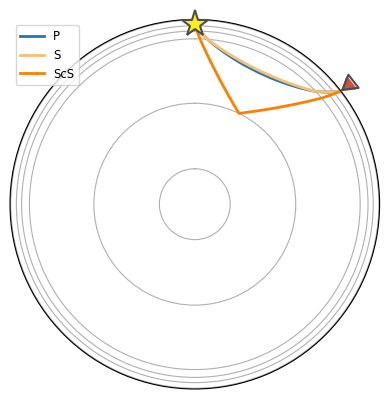

Found 3 ray paths:
  1. P: 535.08 s, 227 points
  2. S: 969.32 s, 276 points
  3. ScS: 1110.00 s, 512 points


In [4]:
# Get ray paths for P and S waves
rays = model.taupy_model.get_ray_paths_geo(
    source_depth_in_km=source_depth,
    source_latitude_in_deg=source_lat,
    source_longitude_in_deg=source_lon,
    receiver_latitude_in_deg=receiver_lat,
    receiver_longitude_in_deg=receiver_lon,
    phase_list=["P", "S", "ScS"]
)

rays.plot()

print(f"Found {len(rays)} ray paths:")
for i, ray in enumerate(rays):
    print(f"  {i+1}. {ray.phase.name}: {ray.time:.2f} s, {len(ray.path)} points")

## 4. Compute Ray Path Lengths

Calculate how much each ray travels through each mesh cell.

In [5]:
# Compute and store path lengths for each ray
P_ray = rays[0]  # First ray (P wave)
S_ray = rays[1] if len(rays) > 1 else rays[0]  # Second ray (S wave)
ScS_ray = rays[2]

# Method 1: Simple computation and storage
P_lengths = model.mesh.add_ray_to_mesh(P_ray, "P_wave")
S_lengths = model.mesh.add_ray_to_mesh(S_ray, "S_wave")
ScS_lengths = model.mesh.add_ray_to_mesh(ScS_ray, "ScS_wave")

print(f"P wave: {P_lengths.sum():.1f} km total, {np.count_nonzero(P_lengths)} cells")
print(f"S wave: {S_lengths.sum():.1f} km total, {np.count_nonzero(S_lengths)} cells")
print(f"ScS wave: {ScS_lengths.sum():.1f} km total, {np.count_nonzero(ScS_lengths)} cells")

# Show stored properties
ray_keys = [k for k in model.mesh.mesh.cell_data.keys() if 'ray_' in k]
print(f"Stored ray properties: {ray_keys}")

Stored ray path lengths as cell data: 'ray_P_wave_P_lengths'
Stored ray path lengths as cell data: 'ray_S_wave_S_lengths'
Stored ray path lengths as cell data: 'ray_ScS_wave_ScS_lengths'
P wave: 5744.2 km total, 27 cells
S wave: 5722.8 km total, 28 cells
ScS wave: 7054.3 km total, 32 cells
Stored ray properties: ['ray_P_wave_P_lengths', 'ray_S_wave_S_lengths', 'ray_ScS_wave_ScS_lengths']


### And visualization

Background P-wave velocity:


/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


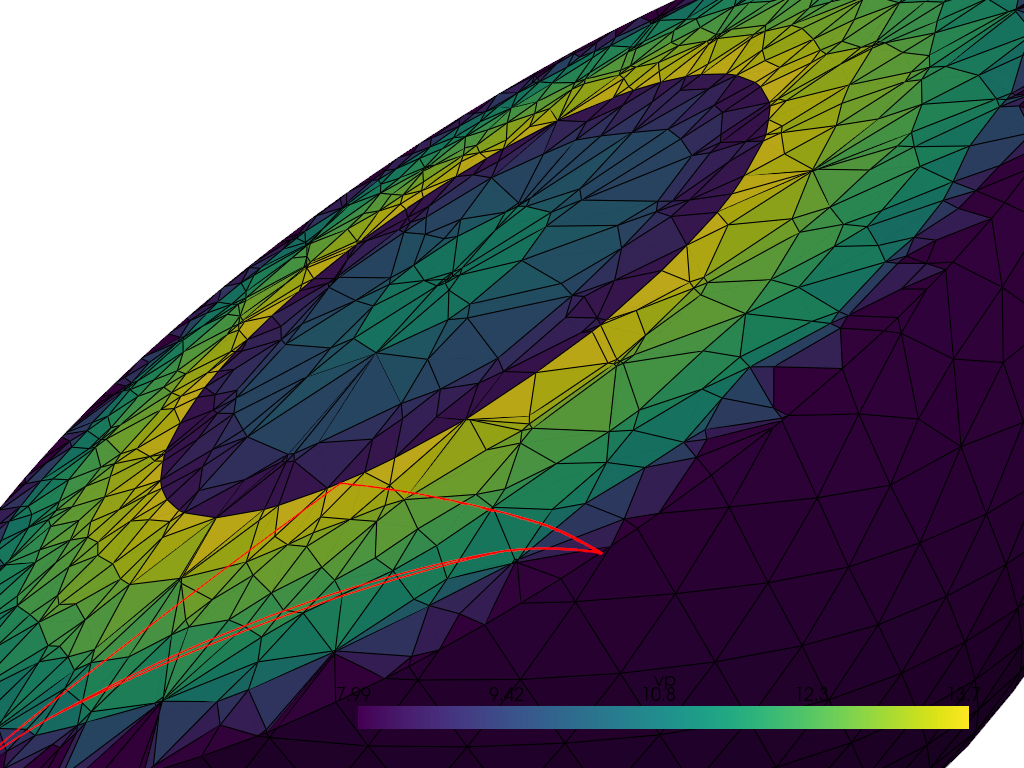

In [6]:
# Cross-section showing background Vp
print("Background P-wave velocity:")
plotter1 = model.mesh.plot_cross_section(
    plane_normal=plane_normal,
    property_name='vp',
    show_rays=rays,  # Overlay ray path
)
plotter1.camera.position = (8000, 6000, 10000)
# Use INTERACTIVE switch to control whether show() presents an interactive widget or a static render.
# If INTERACTIVE is False and you want an image, call plotter1.screenshot('vp_background.png')
plotter1.show(interactive=INTERACTIVE)


P-wave path lengths through cells:


/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


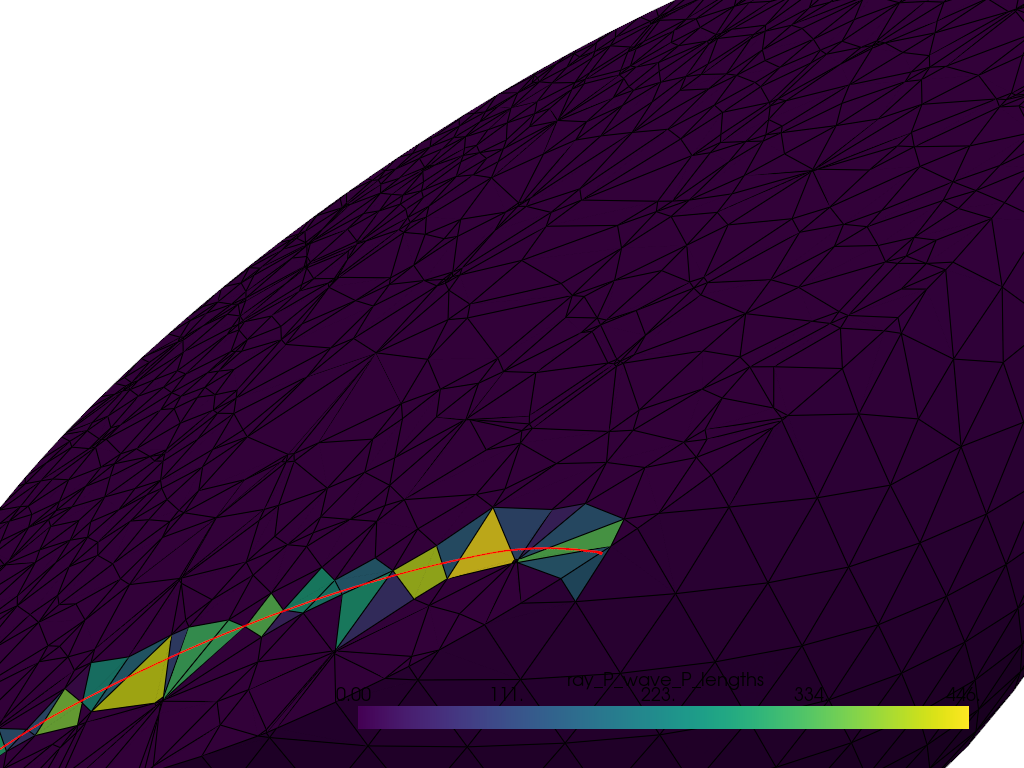

In [7]:
# Cross-section showing P-wave ray path lengths
print("P-wave path lengths through cells:")
plotter2 = model.mesh.plot_cross_section(
    plane_normal=plane_normal,
    property_name='ray_P_wave_P_lengths',
    show_rays=[P_ray],
)
plotter2.camera.position = (8000, 6000, 10000)
# Use INTERACTIVE switch
plotter2.show(interactive=INTERACTIVE)

## 5. Sensitivity Kernels

Compute travel-time sensitivity kernels: K = -L / v² for each cell.

In [8]:
# Compute sensitivity kernels for P and S waves
P_kernel = model.mesh.compute_sensitivity_kernel(
    P_ray, property_name='vp', attach_name='K_P_vp', epsilon=1e-6
)
S_kernel = model.mesh.compute_sensitivity_kernel(
    S_ray, property_name='vs', attach_name='K_S_vs', epsilon=1e-6
)
ScS_kernel = model.mesh.compute_sensitivity_kernel(
    ScS_ray, property_name='vs', attach_name='K_ScS_vs', epsilon=1e-6
)
print(f"P kernel range: {P_kernel.min():.6f} to {P_kernel.max():.6f} s²/km³")
print(f"S kernel range: {S_kernel.min():.6f} to {S_kernel.max():.6f} s²/km³")
print(f"ScS kernel range: {ScS_kernel.min():.6f} to {ScS_kernel.max():.6f} s²/km³")
print(f"Non-zero P kernel cells: {np.count_nonzero(P_kernel)}")
print(f"Non-zero S kernel cells: {np.count_nonzero(S_kernel)}")
print(f"Non-zero ScS kernel cells: {np.count_nonzero(ScS_kernel)}")

Stored sensitivity kernel as cell data: 'K_P_vp'
Stored sensitivity kernel as cell data: 'K_S_vs'
Stored sensitivity kernel as cell data: 'K_ScS_vs'
P kernel range: -4.445166 to -0.000000 s²/km³
S kernel range: -15.025224 to -0.000000 s²/km³
ScS kernel range: -14.829440 to -0.000000 s²/km³
Non-zero P kernel cells: 27
Non-zero S kernel cells: 28
Non-zero ScS kernel cells: 32


In [9]:
print(np.min(P_kernel))

-4.445165559891116


/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


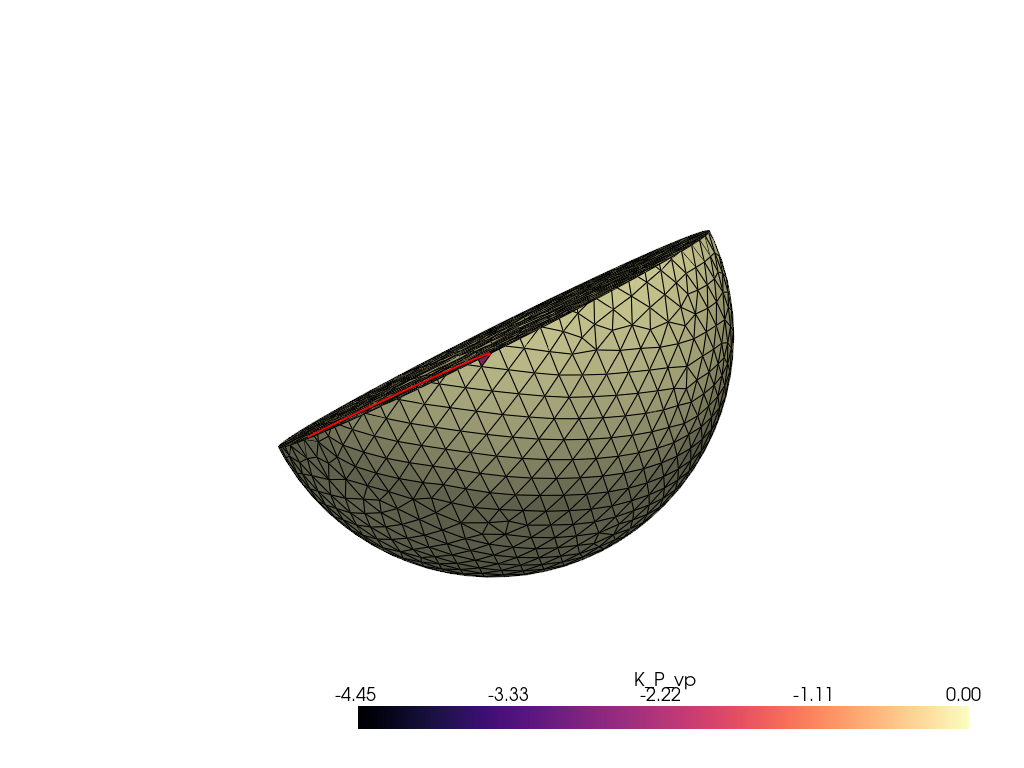

In [10]:
plotter3 = model.mesh.plot_cross_section(
    plane_normal,
    property_name='K_P_vp',
    show_rays=[P_ray],
    cmap='magma',
)
# Interactive display for kernel cross-section
plotter3.show(interactive=INTERACTIVE)

## 6. Multiple Ray Kernels

Combine kernels from multiple rays for enhanced sensitivity.

In [11]:
# Sum kernels from multiple rays
if len(rays) >= 2:
    combined_kernel = model.mesh.compute_sensitivity_kernels_for_rays(
        rays[1:],  # Use first two rays
        property_name='vs',
        attach_name='K_combined_vs',
        accumulate='sum'
    )
    print(f"Combined kernel range: {combined_kernel.min():.6f} to {combined_kernel.max():.6f}")
    print(f"Combined kernel non-zero cells: {np.count_nonzero(combined_kernel)}")

Stored summed sensitivity kernel as cell data: 'K_combined_vs'
Combined kernel range: -26.630041 to 0.000000
Combined kernel non-zero cells: 47


/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


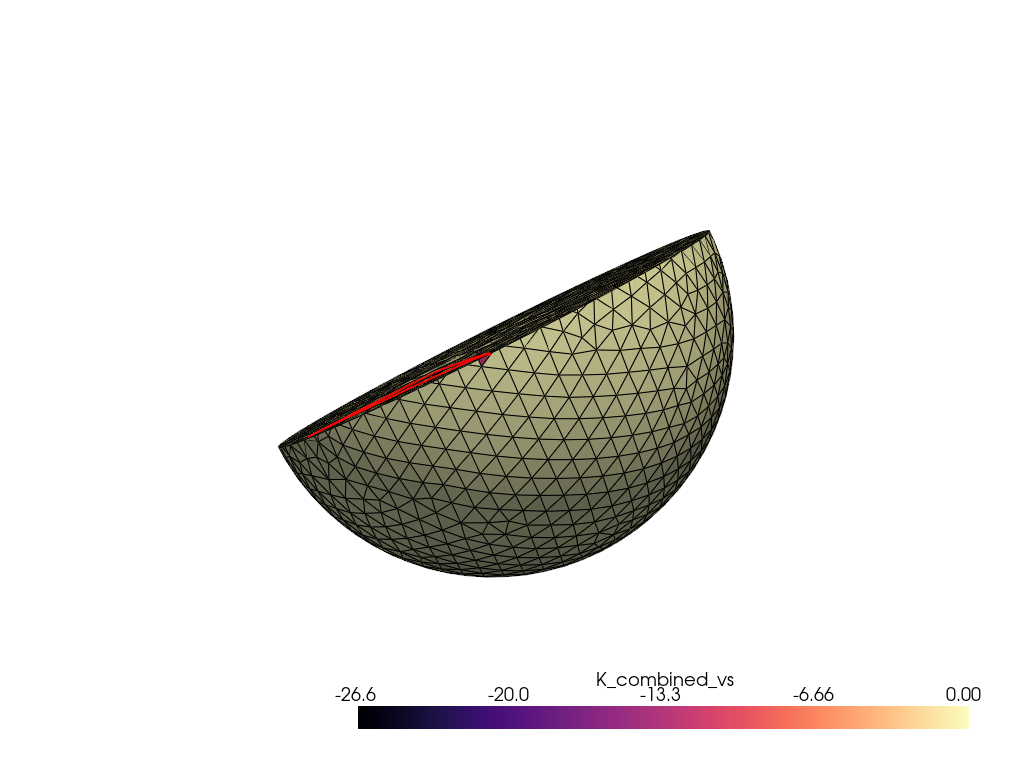

In [12]:
plotter4 = model.mesh.plot_cross_section(
    plane_normal,
    property_name='K_combined_vs',
    show_rays=[S_ray, ScS_ray],
    cmap='magma',
)
# Interactive display
plotter4.show(interactive=INTERACTIVE)

## 8. Export Results

Save mesh with all computed properties for further analysis.

In [13]:
# Save mesh with rays and kernels
model.mesh.save('prem_mesh_with_rays_kernels')

# Show what was saved
info = model.mesh.list_properties(show_stats=False)
print(f"Saved {len(info['cell_data'])} properties to VTU file:")
for prop in info['cell_data'].keys():
    print(f"  - {prop}")

print("\nFiles created:")
print("  - prem_mesh_with_rays_kernels.vtu (mesh + all data)")
print("  - prem_mesh_with_rays_kernels_metadata.json (property list)")

Saved mesh to prem_mesh_with_rays_kernels.vtu
Saved metadata to prem_mesh_with_rays_kernels_metadata.json
Mesh properties summary:
  cell_data keys: ['gmsh:physical', 'gmsh:geometrical', 'layer_0-layer_1-layer_2-gmsh:bounding_entities', 'region', 'vp', 'vs', 'rho', 'ray_P_wave_P_lengths', 'ray_S_wave_S_lengths', 'ray_ScS_wave_ScS_lengths', 'K_P_vp', 'K_S_vs', 'K_ScS_vs', 'K_combined_vs']
Saved 14 properties to VTU file:
  - gmsh:physical
  - gmsh:geometrical
  - layer_0-layer_1-layer_2-gmsh:bounding_entities
  - region
  - vp
  - vs
  - rho
  - ray_P_wave_P_lengths
  - ray_S_wave_S_lengths
  - ray_ScS_wave_ScS_lengths
  - K_P_vp
  - K_S_vs
  - K_ScS_vs
  - K_combined_vs

Files created:
  - prem_mesh_with_rays_kernels.vtu (mesh + all data)
  - prem_mesh_with_rays_kernels_metadata.json (property list)
